In [2]:
import tensorflow as tf 
import tensorflow_docs as tfds 
import numpy as np 
import pandas as pd 
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import tensorflow_docs.modeling
import IPython
import kerastuner as kt
from tensorflow.keras import regularizers

In [3]:
data_input = pd.read_csv("data.csv")
data_input = data_input.dropna()
class_name = []
# for name, columns in data_input.items():
#     class_name.append(name)
# class_name
data_features = data_input.copy()
data_label = data_features.pop('Bankrupt?')
data_features.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,operating gross margin,realized sales gross margin,operating profit rate,tax Pre-net interest rate,after-tax net interest rate,non-industry income and expenditure/revenue,continuous interest rate (after tax),...,net income to total assets,total assets to GNP price,No-credit interval,Gross profit to Sales,Net income to stockholder's Equity,liability to equity,Degree of financial leverage (DFL),Interest coverage ratio( Interest expense to EBIT ),one if net income was negative for the last two year zero otherwise,equity to liability
0,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,0.781241,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,0.781550,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [50]:
data_label.value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

In [4]:
X_train, X_test, y_train, y_test = train_test_split(np.array(data_features),np.array(data_label), test_size= 0.2, random_state= 42)


In [5]:
# normalizer dữ liệu về cùng 1 khoảng giá trị 
normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
normalizer.adapt(np.array(data_features))

In [6]:
def callbacks ():
    return[
        tfds.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience= 200)
    ]

In [7]:
def build_model(hp):
    model = keras.Sequential()
    model.add(normalizer)
    hp_int = hp.Choice('number', values =[1,2,3,4,5])
    for i in range(hp_int):
        hp_units = hp.Choice('units', values = [32,64,128,512])
        hp_regu =hp.Choice('regu', values = [0.1,0.01,0.001,0.0001])
        model.add(layers.Dense(units = hp_units, kernel_regularizer=regularizers.l2(hp_regu), activation= 'elu'))
        hp_rate = hp.Choice( 'rate ', values = [0.0,0.2,0.3,0.4,0.5])
        model.add(layers.Dropout(hp_rate))
    model.add(layers.Dense(1))
    model.compile(
        optimizer= 'adam',
        loss = keras.losses.BinaryCrossentropy(from_logits = True),
        metrics = tf.metrics.BinaryAccuracy(threshold = 0.0)
    )
    return model

In [20]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [21]:
tuner = kt.Hyperband(
    build_model,
    objective='val_binary_accuracy',
    max_epochs = 10,
    factor = 3,
    directory = 'my_dir',
    project_name = 'my_model'
)

In [22]:
tuner.search(X_train, y_train, epochs = 10, validation_data = (X_test, y_test), callbacks= [ClearTrainingOutput(), callbacks()])


Trial 30 Complete [00h 00m 13s]
val_binary_accuracy: 0.9670087695121765

Best val_binary_accuracy So Far: 0.9670087695121765
Total elapsed time: 00h 03m 38s
INFO:tensorflow:Oracle triggered exit


In [23]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
best_hps.values


{'number': 3,
 'units': 64,
 'regu': 0.01,
 'rate ': 0.5,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '83f72381a03558b11b0779b021e9e58f'}

In [24]:
# print(f"""
# The hyperparameter search is complete. The optimal number of units in the first densely-connected
# layer is {best_hps.get('units')} , the optimal rate for the optimizer
# is {best_hps.get('rate ')} and {best_hps.get('int')} of layers.
# """)

In [40]:
my_model = tuner.hypermodel.build(best_hps)
history = my_model.fit(X_train, y_train, epochs = 500, validation_data = (X_test, y_test), callbacks = callbacks(),verbose = 0)


Epoch: 0, binary_accuracy:0.8983,  loss:1.7809,  val_binary_accuracy:0.9655,  val_loss:1.1760,  
....................................................................................................
Epoch: 100, binary_accuracy:0.9672,  loss:0.1091,  val_binary_accuracy:0.9655,  val_loss:0.1142,  
....................................................................................................
Epoch: 200, binary_accuracy:0.9698,  loss:0.1101,  val_binary_accuracy:0.9663,  val_loss:0.1185,  
....................................................................................................
Epoch: 300, binary_accuracy:0.9676,  loss:0.1085,  val_binary_accuracy:0.9655,  val_loss:0.1125,  
....................................................................................................
Epoch: 400, binary_accuracy:0.9694,  loss:0.1115,  val_binary_accuracy:0.9648,  val_loss:0.1170,  
....................................................................................................

In [43]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 95)                191       
_________________________________________________________________
dense (Dense)                (None, 64)                6144      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

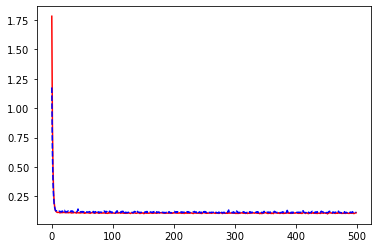

In [44]:
ahihi = history.history
import matplotlib.pyplot as plt 
plt.plot(ahihi['loss'], '-', c = 'red')
plt.plot(ahihi['val_loss'], '--', c = 'blue')
plt.show()

In [47]:
y_predict = my_model.predict(np.array(X_test))
evaluate = my_model.evaluate(X_test, y_test, verbose = 0)
y_predict


array([[-5.303872 ],
       [-5.4975204],
       [-8.426384 ],
       ...,
       [-2.893786 ],
       [-3.460329 ],
       [-7.189295 ]], dtype=float32)

In [48]:
probability_model = tf.keras.Sequential([my_model, layers.Activation('sigmoid')])

y_predict = probability_model.predict(X_test)
for i in range (100):
    print(y_predict[i], ' vs ', y_test[i])

[0.0049477]  vs  0
[0.0040802]  vs  0
[0.00021896]  vs  0
[0.25775924]  vs  1
[0.0431484]  vs  0
[0.0037113]  vs  0
[0.0135661]  vs  0
[0.00253177]  vs  0
[0.00396134]  vs  0
[0.0021342]  vs  0
[0.01161144]  vs  0
[0.04364746]  vs  0
[0.005334]  vs  0
[0.14639021]  vs  0
[0.00062326]  vs  0
[0.04353936]  vs  0
[0.00058521]  vs  0
[0.00355092]  vs  0
[0.0073179]  vs  0
[0.00052845]  vs  0
[0.00718082]  vs  0
[0.01658342]  vs  0
[0.17093797]  vs  0
[0.00056373]  vs  0
[0.002361]  vs  0
[0.02064084]  vs  0
[0.00019489]  vs  0
[0.02549975]  vs  0
[0.16592185]  vs  0
[0.1475988]  vs  1
[0.00899772]  vs  0
[0.00276427]  vs  0
[0.00037626]  vs  0
[0.00093044]  vs  0
[0.00127796]  vs  0
[0.00104167]  vs  0
[0.00026957]  vs  0
[0.03717208]  vs  1
[0.00253696]  vs  0
[0.0008276]  vs  0
[0.00807761]  vs  0
[0.17249236]  vs  0
[0.00021786]  vs  0
[0.00750595]  vs  0
[7.963503e-05]  vs  0
[0.00495114]  vs  0
[0.00069265]  vs  0
[0.51199466]  vs  0
[0.0119034]  vs  0
[0.00610442]  vs  0
[0.00060351]

In [51]:
my_model.save('my_model')
reloaded = tf.keras.models.load_model('my_model')

INFO:tensorflow:Assets written to: my_model\assets


In [55]:
score = reloaded.evaluate(X_test, y_test,verbose = 0)
score

[0.11356145888566971, 0.9677419066429138]

In [57]:
y_predict = reloaded.predict(X_test)
